In [2]:
# Imports
import pandas as pd
import numpy as np
from scipy.stats.mstats import winsorize
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
# Display full columns in output
pd.set_option('display.max_columns', 100)

In [4]:
# Load dataset
df = pd.read_csv("../data/crop1.csv")
#url = "https://huggingface.co/datasets/syazayacob/crop1/resolve/main/crop1.csv"
#df = pd.read_csv(url)


In [5]:
print(df.head(3))

          Area                 Item         Element  Year Unit   Value
0  Afghanistan  Almonds, with shell  Area harvested  1975   ha     0.0
1  Afghanistan  Almonds, with shell  Area harvested  1976   ha  5900.0
2  Afghanistan  Almonds, with shell  Area harvested  1977   ha  6000.0


In [6]:
# --- 1. Filter Relevant Elements and Years ---
relevant_elements = ['Production', 'Area harvested', 'Yield']
df = df[df['Element'].isin(relevant_elements)]
df = df[df['Year'].between(1961, 2020)]

In [7]:
print(df["Element"].unique())
print(df["Year"].min(), df["Year"].max())

['Area harvested' 'Yield' 'Production']
1961 2020


In [8]:
# Combine Element and Unit
df["Element_Unit"] = df["Element"] + " (" + df["Unit"] + ")"

In [9]:
print(df[["Element", "Unit", "Element_Unit"]].drop_duplicates().head())

           Element    Unit         Element_Unit
0   Area harvested      ha  Area harvested (ha)
46           Yield   hg/ha        Yield (hg/ha)
91      Production  tonnes  Production (tonnes)


In [10]:
# --- 2. Handle Missing Values ---
df = df.dropna(subset=["Value"])

In [11]:
print(df.isna().sum())

Area            0
Item            0
Element         0
Year            0
Unit            0
Value           0
Element_Unit    0
dtype: int64


In [12]:
# --- 3. Winsorization ---
df["Value_winsor"] = winsorize(df["Value"], limits=[0.01, 0.01])

In [13]:
print(df[["Value", "Value_winsor"]].head())

    Value  Value_winsor
0     0.0           6.0
1  5900.0        5900.0
2  6000.0        6000.0
3  6000.0        6000.0
4  6000.0        6000.0


In [14]:
# --- 4. Log Transformation ---
df["Value_log"] = np.log1p(df["Value_winsor"])  # log(1 + x) handles 0 safely

In [15]:
print(df[["Value_winsor", "Value_log"]].head())

   Value_winsor  Value_log
0           6.0   1.945910
1        5900.0   8.682877
2        6000.0   8.699681
3        6000.0   8.699681
4        6000.0   8.699681


In [16]:
# --- 5. Decade Binning ---
df["Decade"] = (df["Year"] // 10) * 10

In [17]:
print(df[["Year", "Decade"]].drop_duplicates().sort_values("Year").head(5))

     Year  Decade
292  1961    1960
293  1962    1960
294  1963    1960
295  1964    1960
296  1965    1960


In [18]:
# --- 6. Pivot Table for Raw Values ---
pivot_df = df.pivot_table(
    index=["Area", "Item", "Year"],
    columns="Element",
    values="Value",
    aggfunc="mean"
).reset_index()

In [19]:
print(pivot_df.head(3))

Element         Area                 Item  Year  Area harvested  Production  \
0        Afghanistan  Almonds, with shell  1975             0.0         0.0   
1        Afghanistan  Almonds, with shell  1976          5900.0      9800.0   
2        Afghanistan  Almonds, with shell  1977          6000.0      9000.0   

Element    Yield  
0            NaN  
1        16610.0  
2        15000.0  


In [20]:
# --- 7. Pivot Table for Log-Transformed Values ---
pivot_df_log = df.pivot_table(
    index=["Area", "Item", "Year"],
    columns="Element",
    values="Value_log",
    aggfunc="mean"
).reset_index()

In [21]:
print(pivot_df_log.head(3))

Element         Area                 Item  Year  Area harvested  Production  \
0        Afghanistan  Almonds, with shell  1975        1.945910    1.945910   
1        Afghanistan  Almonds, with shell  1976        8.682877    9.190240   
2        Afghanistan  Almonds, with shell  1977        8.699681    9.105091   

Element     Yield  
0             NaN  
1        9.717820  
2        9.615872  


In [22]:
import os

# Create folder if it doesn't exist
os.makedirs("../data/improve", exist_ok=True)

In [23]:
# Save Cleaned Data
df.to_csv("../data/improve/crop1_clean.csv", index=False)
pivot_df.to_csv("../data/improve/crop_data_pivot.csv", index=False)
pivot_df_log.to_csv("../data/improve/crop_data_pivot_log.csv", index=False)

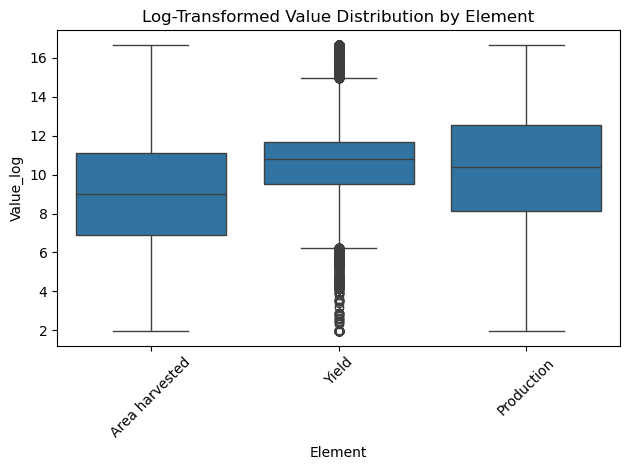

In [24]:
# --- 9. Optional: Visualize Distribution ---
sns.boxplot(data=df, x="Element", y="Value_log")
plt.title("Log-Transformed Value Distribution by Element")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()